# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import module_mma

import pandas as pd
import numpy as np

import sknetwork as skn
from sknetwork.data import from_edge_list, from_adjacency_list, from_graphml, from_csv
from sknetwork.visualization import svg_graph, svg_bigraph
from scipy.sparse import csr_matrix
from IPython.display import SVG

In [3]:
# get data
df_fights = pd.read_csv("data\data.csv").loc[:, ["R_fighter", "B_fighter"]]
df_fighters = pd.melt(df_fights).drop(columns="variable"
                ).rename(columns={"value":"fighter"}
                ).groupby("fighter"
                ).agg({"fighter":"count"}
                ).rename(columns={"fighter":"count"}
                ).reset_index(
                )

print("Number of fighters : {}\nNumber of fights : {}".format(len(df_fighters), len(df_fights)))

Number of fighters : 2139
Number of fights : 6012


In [4]:
# create graph
edge_list = list(df_fights.loc[:, ["R_fighter", "B_fighter"]].itertuples(index=False))
graph = from_edge_list(edge_list)
adjacency = graph.adjacency
graph.node_weights = df_fighters["count"].values

# A fighter's path
Idea : extract the subgraph representing the career of a fighter

In [5]:
def get_fighterGraph(name, graph, max_order=2):

    idx_name = np.where(graph["names"] == name)[0][0]

    opponents = np.where(graph.adjacency.getrow(idx_name).toarray())[1]
    opponents = np.concatenate([opponents, np.array([idx_name])])
    order = 1
    while order<max_order:
        order +=1
    # find secondary opponents
        opponents_nextOrder = np.where((graph.adjacency[opponents]).sum(axis=0))[1]
        opponents = np.unique(np.concatenate([opponents, opponents_nextOrder]))
    # slice graph : names, weights, adjacency_matrix

    graph_name = graph.copy()
    graph_name["names"] = graph_name["names"][opponents]
    graph_name["node_weights"] = graph_name["node_weights"][opponents]
    graph_name["adjacency"] = csr_matrix(graph_name["adjacency"][opponents].toarray()[:,opponents])
    graph_name["labels"] = (graph_name["names"]==name).astype(int)
    
    return graph_name

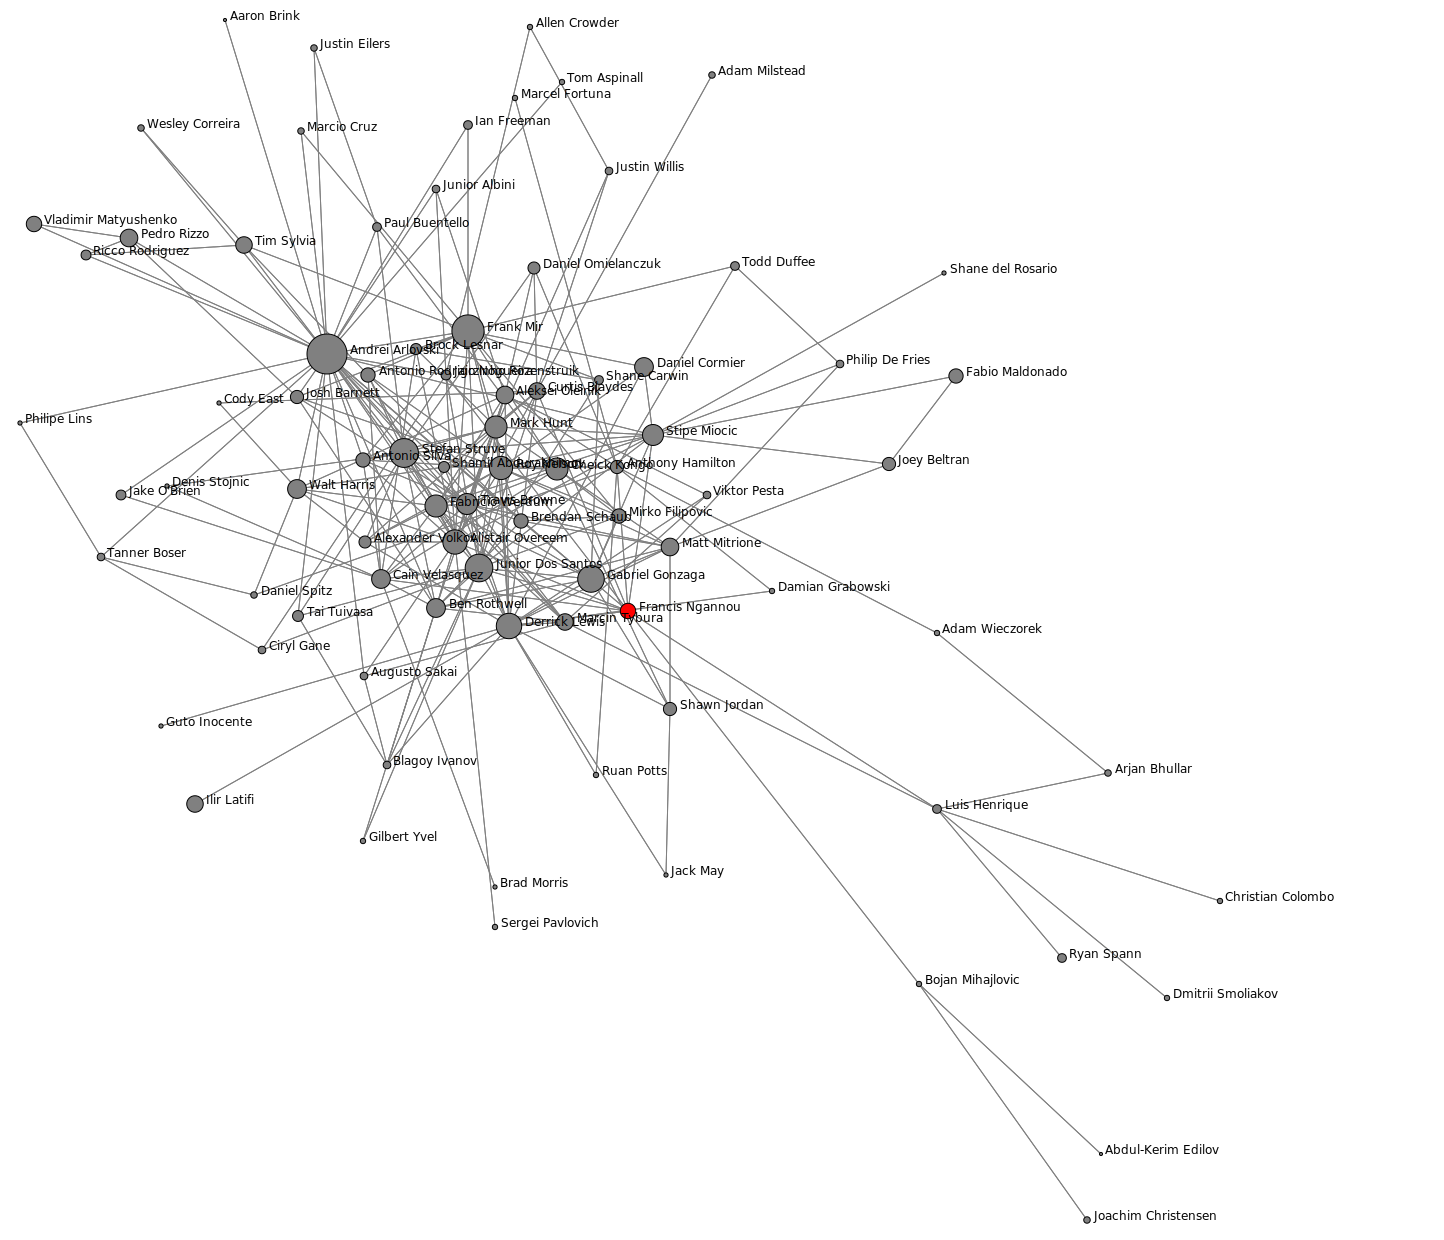

In [6]:
graph_fighter = get_fighterGraph("Francis Ngannou", graph, max_order=2)

# image = svg_graph(adjacency, node_weights=graph.node_weights, display_node_weight=False
#                 , width=1200, height=1200
#                 , node_size_max=5, edge_width_max=2
#                 , display_edges = True, edge_color="gray")

image = svg_graph(graph_fighter["adjacency"], node_weights=graph_fighter["node_weights"]
                    , display_edge_weight=False
                    , names=graph_fighter["names"]
                    , width=1200, height=1200
                    , labels=graph_fighter["labels"]
                    , label_colors=["gray", "red"]
                    )
SVG(image)

# GOATs

In [90]:
import networkx as nx

In [91]:
G = nx.from_scipy_sparse_matrix(graph.adjacency)

C:\Users\leroy\AppData\Local\Temp\ipykernel_16472\1436970925.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(graph.adjacency)


# TODO
- Visualisation :
    - use score to display intensity in the graph (use a measure of centrality computed on the whole graph to use all information) -> do some research on centrality and what would be interesting to display, maybe a way to 
- Find a way to assess "strength" of an mma fighter by this graph (concretely a function that rates the career of a fighter based on his opponents and opponents of opponents) -> do some research on graph summarization, graph scoring...

# <>

In [92]:
# get data
df_fights = pd.read_csv("data\data.csv")
df_fighters = pd.melt(df_fights.loc[:, ["R_fighter", "B_fighter"]]).drop(columns="variable"
                ).rename(columns={"value":"fighter"}
                ).groupby("fighter"
                ).agg({"fighter":"count"}
                ).rename(columns={"fighter":"count"}
                ).reset_index(
                )

print(f"Number of fighters : {len(df_fighters)}\nNumber of fights : {len(df_fights)}")

Number of fighters : 2139
Number of fights : 6012


In [93]:
module_mma.add_nodeAttributes(G, df_fights, df_fighters)

In [95]:
G.nodes[0]

{'primary_weightClass': 'Featherweight-Lightweight',
 'Name': 'Aalon Cruz',
 'mean_weight': 145.0,
 'mean_weight_percentile': 25.596072931276296}

# Export

In [96]:
nx.write_gexf(G, "data/mma_fromnetworkx.gexf")